Tools

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Dataset

In [42]:
df=pd.read_csv("E:\\New journey\\Datasets\\Breast_cancer_data.csv")

In [43]:
df.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0
1,20.57,17.77,132.90,1326.0,0.08474,0
2,19.69,21.25,130.00,1203.0,0.10960,0
3,11.42,20.38,77.58,386.1,0.14250,0
4,20.29,14.34,135.10,1297.0,0.10030,0


In [44]:
df.columns

Index(['mean_radius', 'mean_texture', 'mean_perimeter', 'mean_area',
       'mean_smoothness', 'diagnosis'],
      dtype='object')

Basic EDA

<AxesSubplot:>

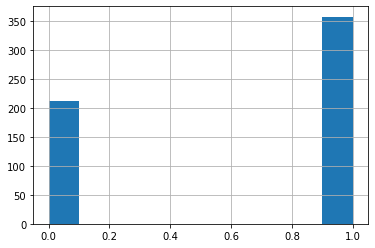

In [45]:
df['diagnosis'].hist()

Checking if the features are independent.

<AxesSubplot:>

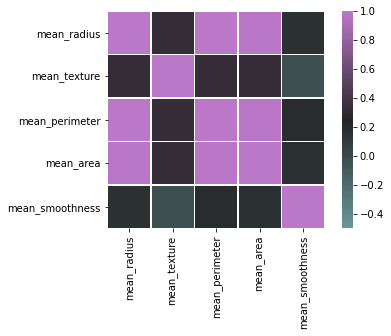

In [46]:
corr= df.iloc[:,:-1].corr(method="pearson")
cmap = sns.diverging_palette(200, 300, 50, 60, center="dark", as_cmap=True)
sns.heatmap(corr, vmax=1, vmin=-.5, cmap=cmap, square=True, linewidths=.2)

In [47]:
df.columns

Index(['mean_radius', 'mean_texture', 'mean_perimeter', 'mean_area',
       'mean_smoothness', 'diagnosis'],
      dtype='object')

In [48]:
df=df[['mean_radius', 'mean_texture','mean_smoothness', 'diagnosis']]

Since the data is continuous, we need to test methods we can use to manage this.
Here we are seeing if normal distribution can be approximated into these ditributions.

<AxesSubplot:xlabel='mean_smoothness', ylabel='Count'>

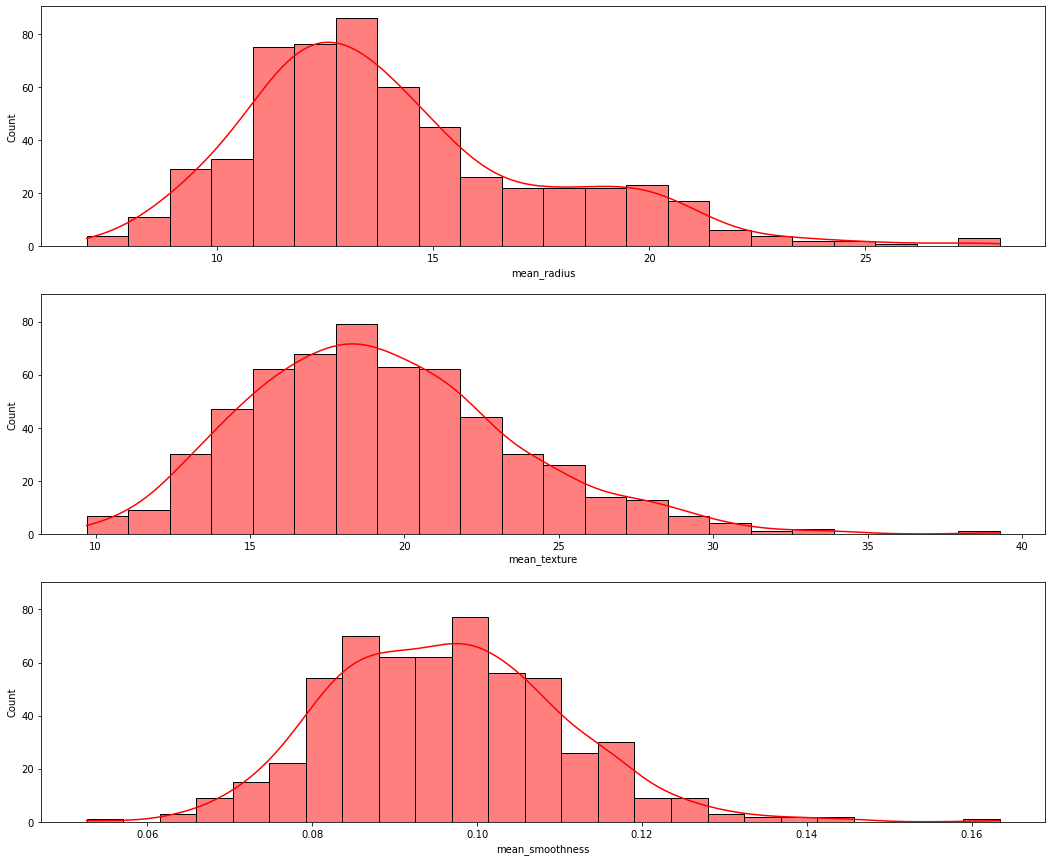

In [49]:
fig,axes=plt.subplots(3,1, figsize=(18,15), sharey=True)
sns.histplot(df, ax=axes[0], x="mean_radius",kde=True, color="r")
sns.histplot(df, ax=axes[1], x="mean_texture", kde=True, color="r")
sns.histplot(df, ax=axes[2], x="mean_smoothness", kde=True, color="r")

mean_texture and mean_smoothness graphs are clearly normal distributions.
For simplicity we are treating mean_radius too as as a normal distribution.

# Calculate P(Y=y) for all possible y

In [50]:
def calculate_prior(df, Y):
    classes= sorted(list(df[Y].unique()))
    prior=[]
    for i in classes:
        prior.append(len(df[df==i])/len(df))
    return prior

# Approach 1: Calculate P(X=x|Y=y) using Gaussian dist.

In [51]:
def calculate_likelihood_gaussian(df, feat_name, feat_val, Y, label):
    feat= list(df.columns)
    df= df[df[Y]==label]
    mean, std = df[feat_name].mean(), df[feat_name].std()
    p_x_given_y = (1/(np.sqrt(2*np.pi)*std)) * np.exp(-((feat_val-mean)**2/(2*std**2)))
    return p_x_given_y

# Calculate P(X=x1|Y=y)P(X=x2|Y=y)P(X=x3|Y=y)...P(X=xn|Y=y) * P(Y=y) for all y and find the maximum

In [52]:
def naive_bayes_gaussian(df, X, Y):
    
    # get features name
    features= list(df.columns)[:-1]
    
    # calculate prior
    prior= calculate_prior(df, Y)
    
    Y_pred=[]
    #loop over every data smaple
    for x in X:
        #calculate likelihood
        labels= sorted(list(df[Y].unique()))
        likelihood=[1]*len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood_gaussian(df, features[i], x[i], Y, labels[j])                
        #Calculate posterior probability
        post_prob =[1]*len(labels)
                
        for j in range(len(labels)):        
            post_prob[j]= likelihood[j] * prior[j]            
                
        Y_pred.append(np.argmax(post_prob))
        
    return(np.array(Y_pred))
        

# Test Gaussian Model

In [53]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=.2, random_state=41)

X_test = test.iloc[:,:-1].values
Y_test = test.iloc[:,-1].values

In [54]:
Y_pred = naive_bayes_gaussian(train, X=X_test, Y="diagnosis")

In [55]:
from sklearn.metrics import confusion_matrix, f1_score
print(confusion_matrix(Y_test, Y_pred))
print(f1_score(Y_test, Y_pred))


[[40  0]
 [ 3 71]]
0.9793103448275862


# Approach 2: Convert continuous features to categorical features

In [56]:
#Binning bing done here
df["cat_mean_radius"]=pd.cut(df["mean_radius"].values, bins=3, labels=[0, 1, 2])
df["cat_mean_texture"]=pd.cut(df["mean_texture"].values, bins=3, labels=[0, 1, 2])
df["cat_mean_smoothness"]=pd.cut(df["mean_smoothness"].values, bins=3, labels=[0, 1, 2])


In [57]:
df=df[['cat_mean_radius', 'cat_mean_texture', 'cat_mean_smoothness', 'diagnosis',]]

In [58]:
def calculate_likelihood_categorical(df, feat_name, feat_val, Y, label):
    feat=list(df.columns)
    df = df[df[Y]==label]
    p_x_given_y = len(df[df[feat_name]==feat_val])/len(df)
    
    return p_x_given_y    

# Approach 2: Calculate P(X=x|Y=y) categorically

In [64]:
def calculate_likelihood_categorical(df, feat_name, feat_val, Y, label):
    feat= list(df.columns)
    df= df[df[Y]==label]
    p_x_given_y= len(df[df[feat_name]==feat_val])/len(df)
    return p_x_given_y

In [67]:
def naive_bayes_categorical(df, X, Y):
    
    # get features name
    features= list(df.columns)[:-1]
    
    # calculate prior
    prior= calculate_prior(df, Y)
    
    Y_pred=[]
    #loop over every data smaple
    for x in X:
        #calculate likelihood
        labels= sorted(list(df[Y].unique()))
        likelihood=[1]*len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j]*= calculate_likelihood_categorical(df, features[i], x[i], Y, labels[j])
                
        #Calculate posterior probability
        post_prob =[1]*len(labels)
                
        for j in range(len(labels)):        
            post_prob[j]= likelihood[j] * prior[j]            
                
        Y_pred.append(np.argmax(post_prob))
        
    return(np.array(Y_pred))
        

In [68]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=.2, random_state=41)

X_test = test.iloc[:,:-1].values
Y_test = test.iloc[:,-1].values

Y_pred = naive_bayes_categorical(train, X=X_test, Y="diagnosis")
from sklearn.metrics import confusion_matrix, f1_score
print(confusion_matrix(Y_test, Y_pred))
print(f1_score(Y_test, Y_pred))


[[38  2]
 [ 5 69]]
0.9517241379310345
